In [1]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
n_neurons = 10
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.1 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.1

In [3]:
@partial(jax.vmap, in_axes=(0, 0))
def dynamics(theta, omega):
    theta = (theta % (2 * jnp.pi)) - jnp.pi
    u = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    v = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    A = (1 - epsilon) * v[:, None] * v[None, :]
    b = u + omega * v
    z = jnp.clip(theta - peaks, -jnp.pi * widths, jnp.pi * widths)
    C = (1 + jnp.cos(z / widths))[:, None] * (
        jnp.tile(u[None, :], (n_neurons, 1))
    )
    return (A, b, C)

def initial_condition(theta, omega):
    m0 = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    S0 = noise_scale * jnp.eye(2)
    return (m0, S0)

def run_dynamics(key, As, bs, Cs, m0, S0):

    def f(x, inp):
        A, b, C, (subkey1, subkey2) = inp
        emission_noise = noise_scale * (
            jxr.multivariate_normal(subkey2, jnp.zeros(n_neurons), jnp.eye(n_neurons))
        )
        y = C @ x + emission_noise

        dynamics_noise = noise_scale * (
            jxr.multivariate_normal(subkey1, jnp.zeros(2), jnp.eye(2))
        )
        x_next = A @ x + b + dynamics_noise
        return x_next, (x_next, y)

    x_init = jxr.multivariate_normal(key, m0, S0)
    subkeys = jxr.split(key, num=(As.shape[0],2))
    _, (x_nexts, ys) = jax.lax.scan(f, x_init, xs=(As, bs, Cs, subkeys))
    # print(x_init)
    # print(x_nexts[0])
    xs = jnp.concatenate([x_init[None, :], x_nexts[:-1]], axis=0)
    return xs, ys

Text(0.5, 1.0, 'heading direction over time')

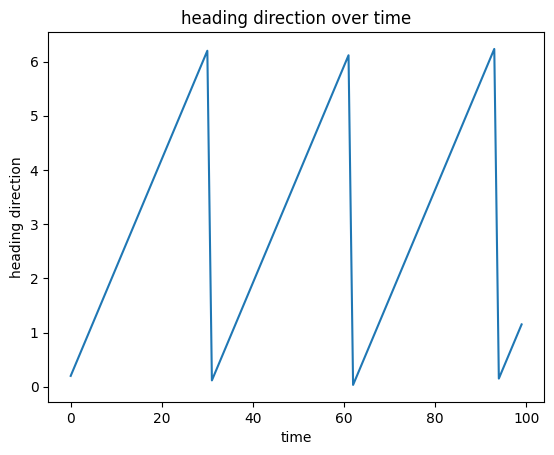

In [4]:
# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

# Plot heading direction trajectory
plt.plot(theta % (2 * jnp.pi))
plt.ylabel('heading direction')
plt.xlabel('time')
plt.title('heading direction over time')

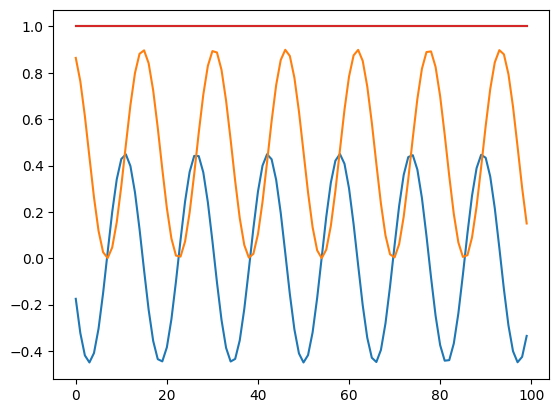

In [5]:
# Generate time-varying linear dynamics and initial condition
true_As, true_bs, true_Cs = dynamics(theta, omega)
true_bs = jnp.ones((num_timesteps, 2))
# true_Cs = jnp.tile(jnp.eye(2), (num_timesteps, 1, 1))
true_C = jxr.normal(jxr.PRNGKey(0), (n_neurons, 2))
true_Cs = jnp.tile(true_C, (num_timesteps, 1, 1))
true_m0, true_S0 = initial_condition(theta[0], omega[0])

# Run the dynamics to get a batch of data
B = 100
X, Y = jax.vmap(
    lambda i: run_dynamics(jxr.PRNGKey(i), true_As, true_bs, true_Cs, true_m0, true_S0)
    )(jnp.arange(B))

partition = int(0.8 * B)
X_train, Y_train = X[:partition], Y[:partition]
X_test, Y_test = X[partition:], Y[partition:]

# plt.plot(Y[0, :])
plt.plot(true_As[:,1])
plt.plot(true_bs)

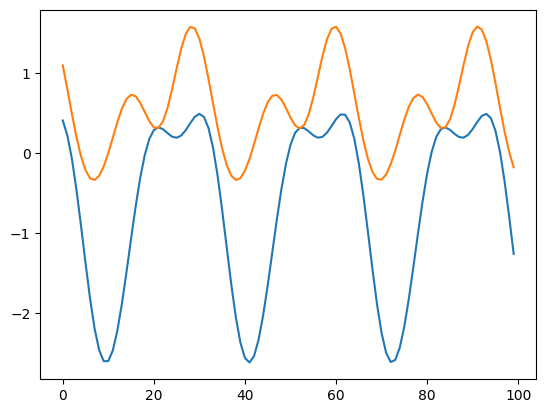

In [6]:
# Define model

_sigma, _kappa, _period = 1.0, 0.2, 2*jnp.pi
torus_basis_funcs = utils.torus_basis(4, _sigma, _kappa, _period)
constant_basis = [lambda x: jnp.ones_like(x)/_period]

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(constant_basis, D1=latent_dim, D2=1)
model = wGPLDS(wgps={'A': A_prior, 'b': b_prior}, state_dim=latent_dim, emission_dim=n_neurons,)

plt.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,0])
plt.plot(A_prior.sample(jxr.PRNGKey(0), theta)[:,0,1])

In [7]:
from models import ParamswGPLDS

# best_log_prob = -jnp.inf
# plt.figure()
# for i in range(3):
#     for j in range(3):
#         print(i,j)
initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.weights(jxr.PRNGKey(0)),
    Q = 0.1 * jnp.eye(latent_dim),
    R = 0.1 * jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    Cs = true_Cs, #jnp.tile(jxr.normal(jxr.PRNGKey(1), (n_neurons, 2)), (num_timesteps, 1, 1)),
    bs = true_bs, #b_prior.sample(jxr.PRNGKey(1), theta[:-1]).squeeze(),
)
thetas_train = jnp.tile(theta[:-1], (B, 1))[:partition]
params, log_probs = model.fit_em(initial_params, emissions=Y_train, inputs=thetas_train, num_iters=50)
# plt.plot(log_probs, label=f'{i},{j}')

    # if log_probs[-1] > best_log_prob:
    #     best_log_prob = log_probs[-1]
    #     best_params = params 
# plt.legend()
# Where does the nan come from? came from S0

Iter 1/50, marginal log-likelihood = -1326454.12
Iter 2/50, marginal log-likelihood = -3189920000.00
Iter 3/50, marginal log-likelihood = -4447927.50
Iter 4/50, marginal log-likelihood = nan
Iter 5/50, marginal log-likelihood = nan
Iter 6/50, marginal log-likelihood = nan
Iter 7/50, marginal log-likelihood = nan
Iter 8/50, marginal log-likelihood = nan
Iter 9/50, marginal log-likelihood = nan
Iter 10/50, marginal log-likelihood = nan
Iter 11/50, marginal log-likelihood = nan
Iter 12/50, marginal log-likelihood = nan
Iter 13/50, marginal log-likelihood = nan
Iter 14/50, marginal log-likelihood = nan
Iter 15/50, marginal log-likelihood = nan
Iter 16/50, marginal log-likelihood = nan
Iter 17/50, marginal log-likelihood = nan
Iter 18/50, marginal log-likelihood = nan
Iter 19/50, marginal log-likelihood = nan
Iter 20/50, marginal log-likelihood = nan
Iter 21/50, marginal log-likelihood = nan
Iter 22/50, marginal log-likelihood = nan
Iter 23/50, marginal log-likelihood = nan
Iter 24/50, marg

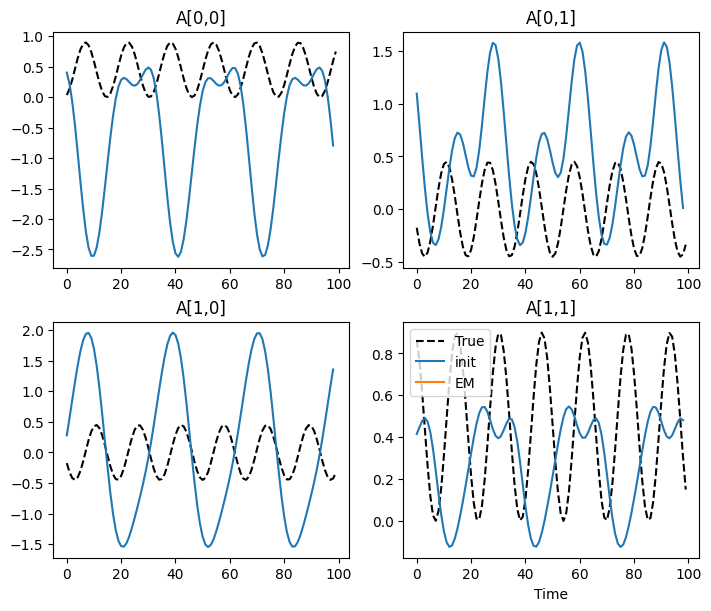

In [8]:
fig, axs = plt.subplots(ncols=latent_dim, nrows=latent_dim, figsize=(7, 6), constrained_layout=True);

for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        ax.plot(true_As[:,i,j], 'k--', label='True')
        ax.plot(A_prior(initial_params.dynamics_gp_weights, theta[:-1])[:,i,j], label='init')
        ax.plot(A_prior(params.dynamics_gp_weights, theta[:-1])[:,i,j], label='EM')
        ax.set_title(f'A[{i},{j}]')
ax.set_xlabel('Time')
ax.legend()

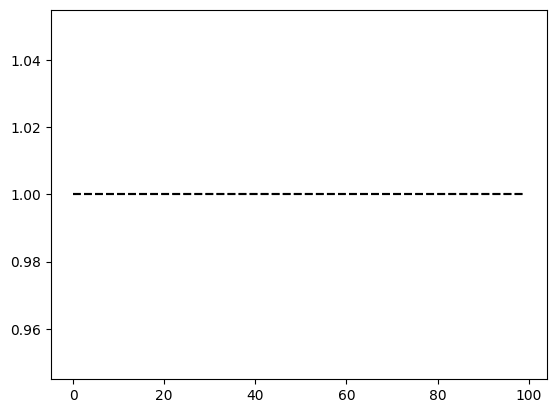

In [9]:
plt.plot(true_bs,'k--');
plt.plot(params.bs, c='tab:orange');

In [10]:
print(f"True diag: {noise_scale**2:.2f}")
print(jnp.diag(params.Q))
print(jnp.diag(params.R))

True diag: 0.01
[nan nan]
[nan nan nan nan nan nan nan nan nan nan]


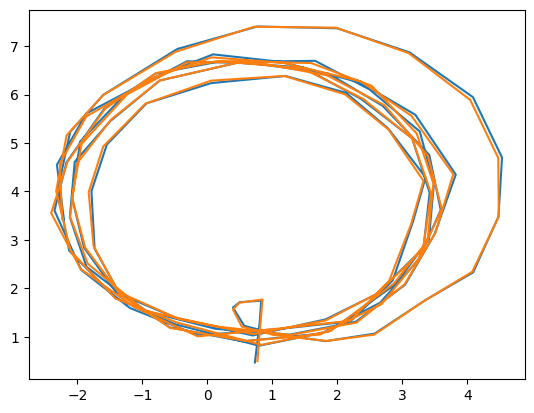

In [11]:
_, (filtered_means, _), (smoothed_means, _, _) = utils.lgssm_smoother(
    m0 = true_m0,
    S0 = true_S0,
    As = true_As,
    bs = true_bs,
    Cs = true_Cs,
    Q = noise_scale * jnp.eye(2),
    R = noise_scale * jnp.eye(n_neurons),
    ys = Y_train[0],
)

plt.plot(X_train[0, :, 0], X_train[0, :, 1], label='true')
plt.plot(smoothed_means[:, 0], smoothed_means[:, 1], label='smoothed')